<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/usage_example(colab)V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/skywalker0803r/c620.git
!pip install autorch > log.txt
!pip install optuna > log.txt

fatal: destination path 'c620' already exists and is not an empty directory.


In [2]:
from c620.FV2 import AllSystem
from c620.configV2 import config
import joblib
import numpy as np
import pandas as pd
import os
os.chdir('/content/c620')
print(os.getcwd())
!git pull

/content/c620
Already up to date.


# demo data

In [3]:
demo = joblib.load('./data/demo.pkl')
print(demo.keys())
icg_input = demo['icg_input']
c620_feed = demo['c620_feed']
t651_feed = demo['t651_feed']

dict_keys(['icg_input', 'c620_feed', 't651_feed', 'c620_op', 'c620_wt', 'c660_op', 'c660_wt', 'c670_op', 'c670_wt'])


# 原本SPEC

In [4]:
icg_input[['Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr']]

,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr
139-017,2.75


In [5]:
icg_input[['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw']]

,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw
139-017,920.0


In [6]:
icg_input[['Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%']]

,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%
139-017,80.0


In [7]:
icg_input[['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw']]

,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw
139-017,2.5


# 第一次試算 簡稱 op1

In [8]:
f = joblib.load('/content/c620/model/allsystem.pkl')
c620_wt1,c620_op1,c660_wt1,c660_op1,c670_wt1,c670_op1 = f.inference(demo['icg_input'].copy(),demo['c620_feed'].copy(),demo['t651_feed'].copy())

In [9]:
na_idx = [1,2,3,4,5,6,8,9,11,13,14,15,20,22,29] 
c660_wt1.filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1).values[0]*10000

938.272138979838

# 第二次 試算 簡稱 op2

* 第二次試算直接代dist=0 觀察輸出NA in BZ 然後寫個if else 判斷是否要再增dist rate

* T651_m3/hr 若大於 150 則 Benzene in C620 Sidedraw_wt%' = 85
* Toluene in Benzene_ppmw 代 10

In [10]:
icg_input2 = demo['icg_input'].copy()

# 第二次試算直接代dist=0 觀察輸出NA in BZ 然後寫個if else 判斷是否要再增dist rate
icg_input2['Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr'] = 0.0

# T651_m3/hr 若大於 150 則 Benzene in C620 Sidedraw_wt%' = 85
if icg_input['Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr'].values[0] > 150:
  icg_input2['Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%'] = 85
  print('Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%=85')
else:
  icg_input2['Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%'] = 70
  print('Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%=70')

# Toluene in Benzene_ppmw 代 10
icg_input2['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw'] = 10

c620_wt2,c620_op2,c660_wt2,c660_op2,c670_wt2,c670_op2 = f.inference(icg_input2.copy(),demo['c620_feed'].copy(),demo['t651_feed'].copy())

Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%=70


In [11]:
na_idx = [1,2,3,4,5,6,8,9,11,13,14,15,20,22,29] 
c660_wt2.filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1).values[0]*10000

1035.5718033767412

# 如上所顯示 當dist rate 直接代0得到1035已經超標了 所以不行

* 想法寫個for迴圈加判斷式將dist rate 往上調 直到c660nainbz <= 980

In [12]:
history={}
history['distrate'] = []
history['nainbz'] = []
from tqdm import tqdm_notebook as tqdm
for dist_rate in tqdm(np.linspace(0,10,100)):
  icg_input2 = demo['icg_input'].copy()
  icg_input2['Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr'] = dist_rate
  c620_wt2,c620_op2,c660_wt2,c660_op2,c670_wt2,c670_op2 = f.inference(icg_input2,demo['c620_feed'],demo['t651_feed'])
  na_idx = [1,2,3,4,5,6,8,9,11,13,14,15,20,22,29] 
  nainbz = c660_wt2.filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1).values[0]*10000
  print(f'dist_rate:{dist_rate} nainbz:{nainbz}')
  history['distrate'].append(dist_rate)
  history['nainbz'].append(nainbz)
  if nainbz <= 980:
    break

dist_rate:0.0 nainbz:1015.7710620743662
dist_rate:0.10101010101010101 nainbz:1015.6697802295117
dist_rate:0.20202020202020202 nainbz:1015.3576578340187
dist_rate:0.30303030303030304 nainbz:1015.166570051951
dist_rate:0.40404040404040403 nainbz:1014.6145704475472
dist_rate:0.5050505050505051 nainbz:1013.9273011122607
dist_rate:0.6060606060606061 nainbz:1013.1869363077391
dist_rate:0.7070707070707071 nainbz:1012.157342100662
dist_rate:0.8080808080808081 nainbz:1010.9316703996794
dist_rate:0.9090909090909091 nainbz:1009.4849539426798
dist_rate:1.0101010101010102 nainbz:1007.8054075919823
dist_rate:1.1111111111111112 nainbz:1005.8800810162985
dist_rate:1.2121212121212122 nainbz:1003.6847270217687
dist_rate:1.3131313131313131 nainbz:1001.1065848925457
dist_rate:1.4141414141414141 nainbz:998.3590094891737
dist_rate:1.5151515151515151 nainbz:995.1072842887207
dist_rate:1.6161616161616161 nainbz:991.6830559865625
dist_rate:1.7171717171717171 nainbz:987.8806717289729
dist_rate:1.818181818181818

dist_rate:1.9191919191919191 nainbz:979.6648434950313


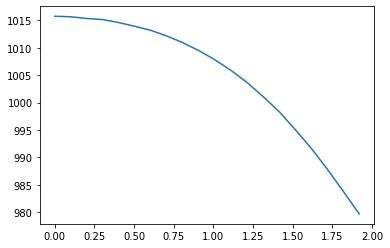

In [13]:
print(f'dist_rate:{dist_rate} nainbz:{nainbz}')
import matplotlib.pyplot as plt

plt.plot(history['distrate'],history['nainbz'])

# 調幅

In [14]:
c620_op2-c620_op1

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
139-017,0.0,0.003102,-0.007321,-0.00003,7.748604e-07,1.079666,-0.064914,-0.012087,0.001541,-0.009705


In [15]:
c660_op2-c660_op1

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
139-017,-0.000001,-0.003125,0.000922,0.000002,-0.000005,1.57592,0.269378,0.223838,0.013359,0.056015


In [16]:
c670_op2-c670_op1

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
139-017,0.0,2.980232e-07,-0.747543,-0.062447,-0.060104,-0.008896,-0.011429
